In [15]:
"""
@author: Miao-Chin Yen
"""

import math
import statistics
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

## Vanilla Option Pricing

In [16]:
"""
    option_type: type of option (call, put)
    barrier_type: type of barrier (up-and-in, up-and-out, down-and-in, down-and-out)
    S: asset inital price
    T: matruity time (year)
    K: strike price
    r: annual interest rate
    q: annual dividend yield
    sigma: volatility
"""

''' vanilla: calculate Black-Scholes PDE solution of vanilla options'''

def vanilla(option_type, S, T, K, r, q, sigma):
    d_1 = (math.log(S/K) + (r  - q + 0.5 * sigma **2) * (T)) / (sigma * math.sqrt(T))
    d_2 = d_1 - (sigma * math.sqrt(T))
    if option_type == 'call':
        return  math.exp(-q * T) * S * norm.cdf(d_1) - K * math.exp(-r * T) * norm.cdf(d_2)
    else:
        return  K * math.exp(-r * T) * norm.cdf(-d_2) - math.exp(-q * T) * S * norm.cdf(-d_1)
    

## Barrier Option Pricing

In [17]:
''' barrier: calculate Black-Scholes PDE solution of barrier options'''

def barrier(barrier_type, option_type, S, T, K, r, q, sigma, B):
    l = (r - q+ (sigma **2) / 2) / (sigma ** 2)
    y = math.log( B **2 / (S * K)) / (sigma * math.sqrt(T)) + l * sigma * math.sqrt(T)
    x_1 = (math.log(S/B)) / (sigma * math.sqrt(T)) + l * sigma * math.sqrt(T)
    x_2 = (math.log(B/S)) / (sigma * math.sqrt(T)) + l * sigma * math.sqrt(T)
    
    if barrier_type == 'down-and-in':
        if  S <= B:
            return vanilla(option_type, S, T, K, r, q, sigma) 
        if K >= B:
            if option_type == 'call':
                return  S * math.exp(-q * T) * (B / S) ** (2 * l) * norm.cdf(y) - K * math.exp(-r * T) * (B / S) ** (2 * l - 2) * norm.cdf(y - sigma * math.sqrt(T))
            else:
                return -S * norm.cdf(-x_1) * math.exp(-q * T) + K * math.exp(-r * T) * norm.cdf(-x_1 + sigma * math.sqrt(T)) + S * math.exp(-q * T) * (B / S) **(2 * l) * (norm.cdf(y) - norm.cdf(x_2)) - K * math.exp(-r * T) * (B/S) ** (2 * l - 2) * (norm.cdf(y - sigma * math.sqrt(T)) - norm.cdf(x_2 - sigma * math.sqrt(T)))
        else: 
            if option_type == 'call':
                return vanilla(option_type, S, T, K, r, q, sigma) - barrier('down-and-out', 'call', S, T, K, r, q, sigma, B) 
            else:
                return vanilla(option_type, S, T, K, r, q, sigma)
                
    if barrier_type == 'down-and-out':
        if S <= B:
            return 0
        if K >= B:
            if option_type == 'call':
                return vanilla(option_type, S, T, K, r, q, sigma) - barrier('down-and-in','call', S, T, K, r, q, sigma, B)
            else:
                return vanilla(option_type, S, T, K, r, q, sigma) - barrier('down-and-in','put', S, T, K, r, q, sigma, B) 
        else:
            if option_type == 'call':
                return S * norm.cdf(x_1) * math.exp(-q * T) - K * math.exp(-r * T) * norm.cdf(x_1 - sigma * math.sqrt(T)) - S * math.exp(-q * T) * (B / S) **(2 * l) * norm.cdf(x_2) + K * math.exp(-r * T) * (B/S) ** (2 * l - 2) * norm.cdf(x_2 - sigma * math.sqrt(T) )
            else:
                return 0
                
    if barrier_type == 'up-and-in':
        if S >= B:
            return  vanilla(option_type, S, T, K, r, q, sigma)
        if K >= B:
            if option_type == 'call':
                return vanilla(option_type, S, T, K, r, q, sigma)
            else:
                return vanilla(option_type, S, T, K, r, q, sigma) - barrier('up-and-out','put', S, T, K, r, q, sigma, B)
                
        else:
            if option_type == 'call':
                return S * norm.cdf(x_1) * math.exp(-q * T) - K * math.exp(-r * T) * norm.cdf(x_1 - sigma * math.sqrt(T)) - S * math.exp(-q * T) * (B / S) **(2 * l) * (norm.cdf(-y) -norm.cdf(-x_2)) + K * math.exp(-r * T) * (B/S) ** (2 * l - 2) * (norm.cdf(-y + sigma * math.sqrt(T)) - norm.cdf(-x_2 + sigma * math.sqrt(T)))
            else:
                return  -S * math.exp(-q * T) * (B/S) ** (2 * l) * norm.cdf(-y) + K * math.exp(-r * T) * (B/S) ** (2 * l - 2) * (norm.cdf(-y + sigma * math.sqrt(T)))
                
    if barrier_type == 'up-and-out':
        if S >= B:
            return 0
        if K >= B:
            if option_type == 'call':
                return 0
            else:
                return -S * norm.cdf(-x_1) * math.exp(-q * T) + K * math.exp(-r * T) * norm.cdf(-x_1 + sigma * math.sqrt(T)) + S * math.exp(-q * T) * (B / S) **(2 * l) * norm.cdf(-x_2) - K * math.exp(-r * T) * (B/S) ** (2 * l - 2) * norm.cdf(-x_2 + sigma * math.sqrt(T))
        else:
            if option_type == 'call':
                return vanilla(option_type, S, T, K, r, q, sigma) - barrier('up-and-in','call', S, T, K, r, q, sigma, B)
            else:
                return  vanilla(option_type, S, T, K, r, q, sigma) - barrier('up-and-in','put', S, T, K, r, q, sigma, B)


## Monte Carlo Simulation 

In [18]:
''' mote_carlo: Monte Carlo simulations for pricing barrier options'''

def monte_carlo(sample_times, barrier_type, option_type, S, T, K, r, sigma, B):
    sample_payoff = []
    for i in range(sample_times):
        sample_path = [S]
        x = S
        for j in range(int(T * 365)):
            x = x * math.exp(np.random.normal((r /365 - 0.5 * sigma **2 /365), sigma  / math.sqrt(365), 1)[0])
            sample_path.append(x)
        if barrier_type == 'down-and-in':
            if min(sample_path) <= B:
                payoff = option_payoff(option_type, K, sample_path[-1])
            else:
                payoff = 0  
        elif barrier_type == 'down-and-out':
            if min(sample_path) <= B:
                payoff = 0
            else:
                payoff = option_payoff(option_type, K, sample_path[-1])
        elif barrier_type == 'up-and-in':
            if max(sample_path) >= B:
                payoff = option_payoff(option_type, K, sample_path[-1])
            else:
                payoff = 0  
        else:
            if max(sample_path) >= B:
                payoff = 0
            else:
                payoff = option_payoff(option_type, K, sample_path[-1])
        sample_payoff.append(math.exp(-r * T) * payoff)
    return statistics.mean(sample_payoff)



''' option_payoff: calculate call/put options payoff'''

def option_payoff(option_type, K, S_T):
    if option_type == 'call':
        return max(S_T - K, 0)    
    else:
        return max(K - S_T, 0)           


-----------------------------------------------
up-and-out call S= 30 K= 30 B= 50
PDE: 1.7043302904365571
Monte Carlo:  1.7841325820153962
up-and-out call S= 35 K= 30 B= 50
PDE: 1.7896794375269298
Monte Carlo:  1.9412902059338744
up-and-out call S= 40 K= 30 B= 50
PDE: 1.4378325182446723
Monte Carlo:  1.6557343368364157
----------------------------------------------
up-and-out call S= 30 K= 30 B= 40
PDE: 0.3066969127087731
Monte Carlo:  0.347516521729987
up-and-out call S= 30 K= 30 B= 45
PDE: 0.9162489049104945
Monte Carlo:  0.967560393541675
up-and-out call S= 30 K= 30 B= 55
PDE: 2.489440868523076
Monte Carlo:  2.5928103191118153
----------------------------------------------
down-and-in put S= 55 K= 50 B= 30
PDE: 2.9960359740569915
Monte Carlo:  2.6914570942324163
down-and-in put S= 40 K= 50 B= 30
PDE: 9.889994622048967
Monte Carlo:  9.53410491463839
down-and-in put S= 35 K= 50 B= 30
PDE: 14.113743525698284
Monte Carlo:  13.818487774003927
---------------------------------------------

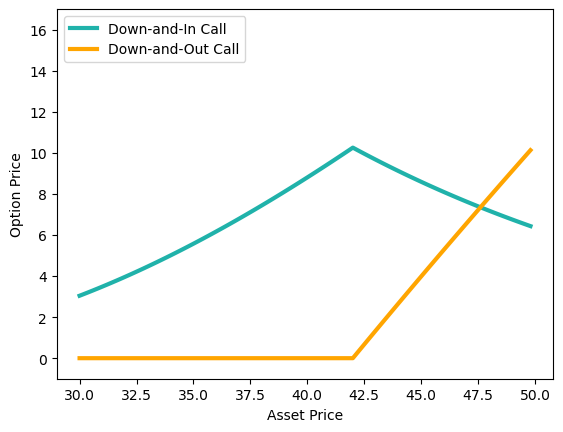

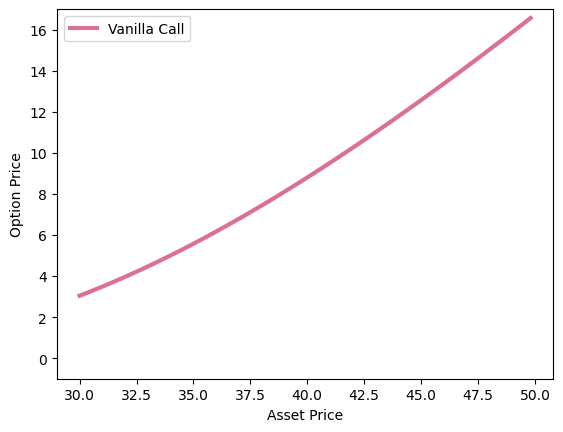

-----------------------------------------------


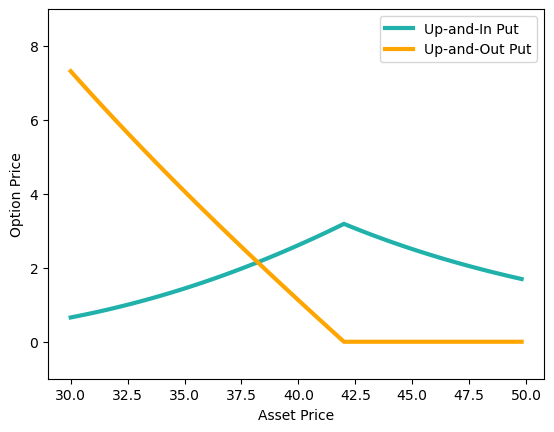

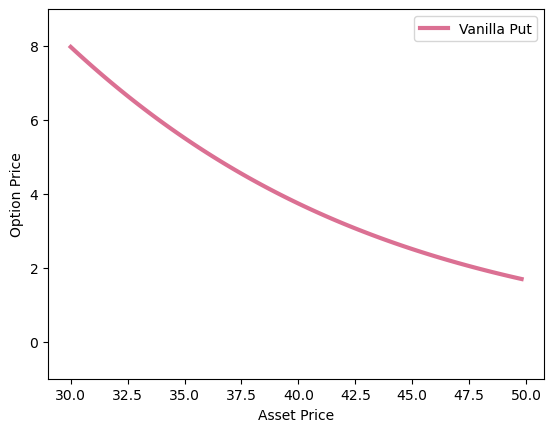

In [19]:
T = 1
r = 0.03 
q = 0
sigma = 0.4 
sample_times = 5000

print('-----------------------------------------------')

S = [30, 35, 40]
B = 50
K = 30
barrier_type = 'up-and-out'
option_type = 'call'
for s in S:
    print(barrier_type , option_type, 'S=', s, 'K=', K, 'B=', B)
    print('PDE:', barrier(barrier_type, option_type, s, T, K, r, q, sigma, B))
    print('Monte Carlo: ',monte_carlo(sample_times, barrier_type, option_type, s, T, K, r, sigma, B))

print('----------------------------------------------')

S = 30
B = [40, 45, 55]
for b in B:
    print(barrier_type , option_type, 'S=', S, 'K=', K, 'B=', b)
    print('PDE:', barrier(barrier_type, option_type, S, T, K, r, q, sigma, b))
    print('Monte Carlo: ',monte_carlo(sample_times, barrier_type, option_type, S, T, K, r, sigma, b))

print('----------------------------------------------')

barrier_type = 'down-and-in'
option_type = 'put'
S = [55, 40, 35]
B = 30
K = 50
for s in S:
    print(barrier_type , option_type, 'S=', s, 'K=', K, 'B=', B)
    print('PDE:', barrier(barrier_type, option_type, s, T, K, r, q, sigma, B))
    print('Monte Carlo: ',monte_carlo(sample_times, barrier_type, option_type, s, T, K, r, sigma, B))

print('-----------------------------------------------')

S = 50
B = [45, 40, 35]
for b in B:
    print(barrier_type , option_type, 'S=', S, 'K=', K, 'B=', b)
    print('PDE:', barrier(barrier_type, option_type, S, T, K, r, q, sigma, b))
    print('Monte Carlo: ',monte_carlo(sample_times, barrier_type, option_type, S, T, K, r, sigma, b))

print('-----------------------------------------------')

S = [s * 0.2 + 30 for s in range(100)]
B = 42
K = 36
option_type = 'call'
down_and_in_call = []
down_and_out_call = []
vanilla_call = []
for s in S:
    down_and_in_call.append(barrier('down-and-in', option_type, s, T, K, r, q, sigma, B))
    down_and_out_call.append(barrier('down-and-out', option_type, s, T, K, r, q, sigma, B))
    vanilla_call.append(vanilla(option_type, s, T, K, r, q, sigma))

plt.plot(S, down_and_in_call, '-', linewidth = 3, color='lightseagreen', label = 'Down-and-In Call')
plt.plot(S, down_and_out_call, '-', linewidth = 3, color = 'orange', label = 'Down-and-Out Call')
plt.xlabel("Asset Price")
plt.ylabel("Option Price")
plt.ylim([-1, 17])
plt.legend(loc='upper left')
plt.title("")
plt.show()

plt.plot(S, vanilla_call, '-', linewidth = 3, color='palevioletred', label = 'Vanilla Call')
plt.xlabel("Asset Price")
plt.ylabel("Option Price")
plt.ylim([-1, 17])
plt.legend(loc='upper left')
plt.title("")
plt.show()

print('-----------------------------------------------')

S = [s * 0.2 + 30 for s in range(100)]
B = 42
K = 36
option_type = 'put'
up_and_in_put = []
up_and_out_put = []
vanilla_put = []
for s in S:
    up_and_in_put.append(barrier('up-and-in', option_type, s, T, K, r, q, sigma, B))
    up_and_out_put.append(barrier('up-and-out', option_type, s, T, K, r, q, sigma, B))
    vanilla_put.append(vanilla(option_type, s, T, K, r, q, sigma))

plt.plot(S, up_and_in_put, '-', linewidth = 3, color='lightseagreen', label = 'Up-and-In Put')
plt.plot(S, up_and_out_put, '-', linewidth = 3, color = 'orange', label = 'Up-and-Out Put')
plt.xlabel("Asset Price")
plt.ylabel("Option Price")
plt.ylim([-1, 9])
plt.legend(loc = 'upper right')
plt.title("")
plt.show()

plt.plot(S, vanilla_put, '-', linewidth = 3, color ='palevioletred', label = 'Vanilla Put')
plt.xlabel("Asset Price")
plt.ylabel("Option Price")
plt.ylim([-1, 9])
plt.legend(loc = 'upper right')
plt.title("")
plt.show()